In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

In [2]:
train_data = pd.read_csv("E:\Echo Dynamic\EchoNet-Dynamic\FileList.csv")

In [3]:
train_data

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL
...,...,...,...,...,...,...,...,...,...
10025,0X234005774F4CB5CD,51.724743,47.065329,97.493690,768,1040,50,127,TRAIN
10026,0X2DC68261CBCC04AE,62.187781,26.333478,69.642772,768,1024,50,66,TRAIN
10027,0X35291BE9AB90FB89,62.070762,49.064338,129.357561,768,1024,50,208,TRAIN
10028,0X6C435C1B417FDE8A,59.635257,57.721170,142.998978,768,1024,50,166,TRAIN


In [4]:
train_data = train_data[train_data.columns[0:2]]


In [5]:
train_4CH_dir = "E:\\Echo Dynamic\\EchoNet-Dynamic\\Videos_test\\"

In [6]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=50, resize=(112, 112)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [7]:
import glob as gb

videos = []
label = []

for folder in  os.listdir(train_4CH_dir) : 
    #files = gb.glob(pathname= str( train_4CH_dir+ '/*.avi'))
    #print(folder)
    videos.append(folder)
    label.append(train_data[train_data["FileName"]==folder.split(".")[0]])
    

0X1A05DFFFCAFB253B.avi
0X1A0A263B22CCD966.avi
0X1A2A76BDB5B98BED.avi
0X1A2C60147AF9FDAE.avi
0X1A2E9496910EFF5B.avi
0X1A3D565B371DC573.avi
0X1A3E7BF1DFB132FB.avi
0X1A5FAE3F9D37794E.avi
0X1A6ACFE7B286DAFC.avi
0X1A8D85542DBE8204.avi


In [9]:
d = np.array(label)

In [11]:
xtrain = []
ytrain = []
train_image = []
for i in range(10):
    xtrain.append(load_video(train_4CH_dir+videos[i]))
    for j in range(xtrain[i].shape[0]):
        ytrain.append(d[i][0][1])    
        # appending the image to the train_image list
        train_image.append(xtrain[i][j])


In [12]:
X = np.array(train_image[:500])
Y = np.array(ytrain[:500])

In [13]:
print(len(train_image))
print(len(ytrain))

500
500


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

In [15]:
#X_train = base_model.predict(image)
X_train.shape

(400, 112, 112, 3)

In [16]:
#X_train = base_model.predict(image)
y_train.shape

(400,)

In [17]:
X_test.shape

(100, 112, 112, 3)

In [18]:
y_test.shape

(100,)

In [19]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'), 
        input_shape=(1,112, 112, 3) # 5 images...
    )
)
model.add(
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.GlobalAveragePooling2D() # Or Flatten()
    )
)
model.add(
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)
)
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile('adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [20]:
X_train = X_train.reshape(400,1,112,112,3)


In [21]:
y_train.shape

(400,)

In [22]:
y_train = y_train.reshape(400,1)

In [23]:
batch_size = 1
num_epoch = 20
#steps = len(os.listdir(train_4CH_dir))//batch_size
history = model.fit(X_train,y_train, epochs=num_epoch, batch_size=batch_size,
                            verbose=1)

Epoch 1/20
400/400 [==============================] - 8s 14ms/step - loss: 592.6508 - root_mean_squared_error: 24.3444
Epoch 2/20
400/400 [==============================] - 5s 13ms/step - loss: 280.2415 - root_mean_squared_error: 16.7404
Epoch 3/20
400/400 [==============================] - 5s 13ms/step - loss: 220.0276 - root_mean_squared_error: 14.8333
Epoch 4/20
400/400 [==============================] - 6s 14ms/step - loss: 132.7310 - root_mean_squared_error: 11.5209
Epoch 5/20
400/400 [==============================] - 5s 14ms/step - loss: 77.3472 - root_mean_squared_error: 8.7947
Epoch 6/20
400/400 [==============================] - 6s 14ms/step - loss: 62.1007 - root_mean_squared_error: 7.8804
Epoch 7/20
400/400 [==============================] - 7s 18ms/step - loss: 49.9162 - root_mean_squared_error: 7.0651
Epoch 8/20
400/400 [==============================] - 5s 13ms/step - loss: 45.0588 - root_mean_squared_error: 6.7126
Epoch 9/20
400/400 [==============================] - 7s

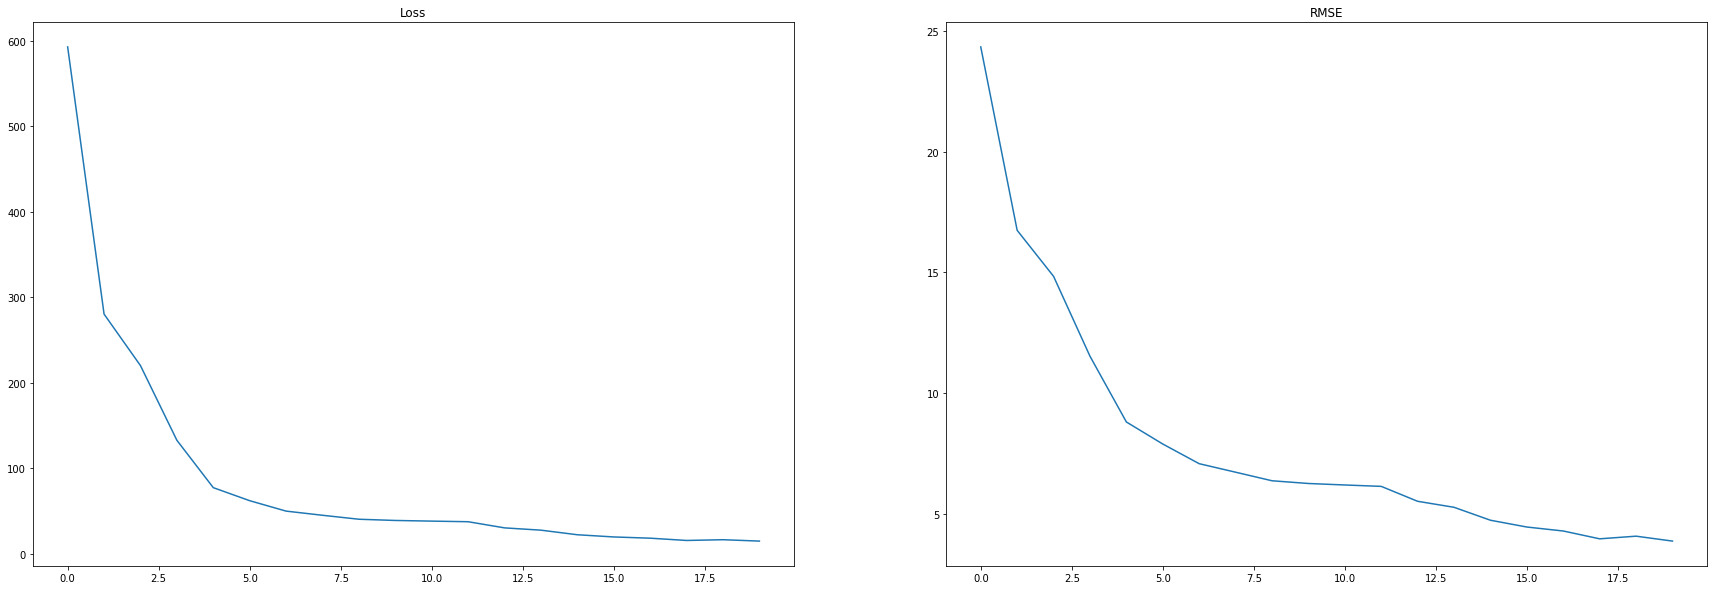

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(30)
ax1.plot(history.history["loss"])
ax1.set_title("Loss")
ax2.plot(history.history["root_mean_squared_error"])
ax2.set_title("RMSE")
plt.show()

In [25]:
X_test = X_test.reshape(100,1,112,112,3)
y_test = y_test.reshape(100,1)

In [26]:
y_pred = model.predict(X_test)

In [27]:
#Calculating Details
print(' Train Score is : ' , model.evaluate(X_train, y_train))
print(' Test Score is : ' , model.evaluate(X_test, y_test))

13/13 [==============================] - 2s 115ms/step - loss: 13.5538 - root_mean_squared_error: 3.6816
 Train Score is :  [13.553823471069336, 3.681551694869995]
4/4 [==============================] - 0s 81ms/step - loss: 17.0304 - root_mean_squared_error: 4.1268
 Test Score is :  [17.03037452697754, 4.1267876625061035]


In [28]:
y_pred[0]

array([51.78344], dtype=float32)

In [29]:
y_test[0]

array([53.51590769])

In [31]:
print("Prediction Values ")
print(y_pred[:5])
print("*****************")
print("Real Values ")
print(y_test[:5])

Prediction Values 
[[51.78344 ]
 [60.159718]
 [51.983276]
 [63.190327]
 [60.845356]]
*****************
Real Values 
[[53.51590769]
 [65.4545286 ]
 [53.51590769]
 [64.17785605]
 [65.42513582]]


In [38]:
X_test[0].shape

(1, 112, 112, 3)

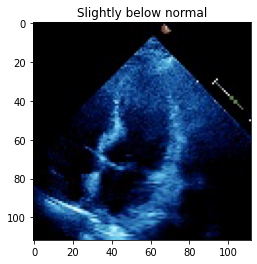

In [48]:
if (y_pred[0] >= 55 and y_pred[0] <= 70):
    plt.imshow(X_test[0].reshape(112,112,3))
    plt.title("Normal")
    plt.show()
elif (y_pred[0] >= 40 and y_pred[0] <= 54):
    plt.imshow(X_test[0].reshape(112,112,3))
    plt.title("Slightly below normal")
    plt.show()
elif (y_pred[0] >= 35 and y_pred[0] <= 39):
    plt.imshow(X_test[0].reshape(112,112,3))
    plt.title("Moderately below normal")
    plt.show()
    
elif (y_pred[0] < 35 ):
    plt.imshow(X_test[0].reshape(112,112,3))
    plt.title("Severely below normal")
    plt.show()
    